<a href="https://colab.research.google.com/github/mohamedhanfi/Car-Type-Classification/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications import DenseNet169

base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [2]:
for layer in base_model.layers:
    layer.trainable=False

In [4]:
# Install the Kaggle package if not already installed
!pip install kaggle

# Download the dataset
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

# Unzip the dataset
!unzip stanford-car-dataset-by-classes-folder.zip -d car_data

Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
100% 1.83G/1.83G [01:23<00:00, 24.3MB/s]
100% 1.83G/1.83G [01:23<00:00, 23.4MB/s]
unzip:  cannot find or open stanford-car-dataset-by-classes-folder.zip -d car_data, stanford-car-dataset-by-classes-folder.zip -d car_data.zip or stanford-car-dataset-by-classes-folder.zip -d car_data.ZIP.


In [7]:
!unzip stanford-car-dataset-by-classes-folder.zip -d car_data

Streaming output truncated to the last 5000 lines.
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/04381.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/04688.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/04772.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/05544.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/05728.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/05860.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06146.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06157.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06332.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06441.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06447.jpg  
  inflating: car_data/car_data/car_data/train/C

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2  # Import l2 regularizer

# Define the paths
train_dir = '/content/car_data/car_data/car_data/train'
val_dir = '/content/car_data/car_data/car_data/test'

# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Data Generator for validation
val_datagen = ImageDataGenerator(rescale=1./255)




In [4]:
# Create data generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False)

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(196, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=outputs)


Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [5]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [6]:
# Train the model
history = model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping, checkpoint, reduce_lr])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.0145 - loss: 16.6757 - val_accuracy: 0.0900 - val_loss: 11.1119 - learning_rate: 1.0000e-04
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 221s 855ms/step - accuracy: 0.1454 - loss: 10.3201 - val_accuracy: 0.3543 - val_loss: 8.0442 - learning_rate: 1.0000e-04
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.3690 - loss: 7.7605 - val_accuracy: 0.5631 - val_loss: 6.5706 - learning_rate: 1.0000e-04
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.5980 - loss: 6.2989 - val_accuracy: 0.6449 - val_loss: 5.7722 - learning_rate: 1.0000e-04
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.7239 - loss: 5.3887 - val_accuracy: 0.7223 - val_loss: 5.0456 - learning_rate: 1.0000e-04
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8092 - loss: 4.6683 - val_accuracy: 0.7382 - val_loss: 4.5928 - learning_rate: 1.0000e-04
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 220s 846ms/step - accur

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [8]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

252/252 ━━━━━━━━━━━━━━━━━━━━ 54s 213ms/step - accuracy: 0.8121 - loss: 3.0145
Validation Loss: 3.0084574222564697
Validation Accuracy: 0.811963677406311


In [9]:
# Get predictions on validation data
val_data.reset()  # Reset the generator for evaluation
predictions = model.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)

252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 209ms/step


In [14]:
print(predicted_classes)

[  4 193 186 ... 171 145  32]


In [23]:
# Get true labels from the validation data generator
true_classes = val_data.classes  # This gives the true labels

# Generate classification report
class_labels = list(val_data.class_indices.keys())  # Get class labels
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Convert metrics to percentage
report_df['precision'] = report_df['precision'] * 100
report_df['recall'] = report_df['recall'] * 100
report_df['f1-score'] = report_df['f1-score'] * 100
report_df['support'] = report_df['support'].astype(int)  # Make support an integer value

# Display the classification report
print(report_df[['precision', 'recall', 'f1-score', 'support']])

                               precision    recall  f1-score  support
AM General Hummer SUV 2000      0.000000  0.000000  0.000000       44
Acura Integra Type R 2001       0.000000  0.000000  0.000000       44
Acura RL Sedan 2012             0.000000  0.000000  0.000000       32
Acura TL Sedan 2012             2.040816  2.325581  2.173913       43
Acura TL Type-S 2008            0.000000  0.000000  0.000000       42
...                                  ...       ...       ...      ...
Volvo XC90 SUV 2007             0.000000  0.000000  0.000000       43
smart fortwo Convertible 2012   0.000000  0.000000  0.000000       40
accuracy                        0.572068  0.572068  0.572068        0
macro avg                       0.552928  0.566692  0.551466     8041
weighted avg                    0.559840  0.572068  0.557714     8041

[199 rows x 4 columns]


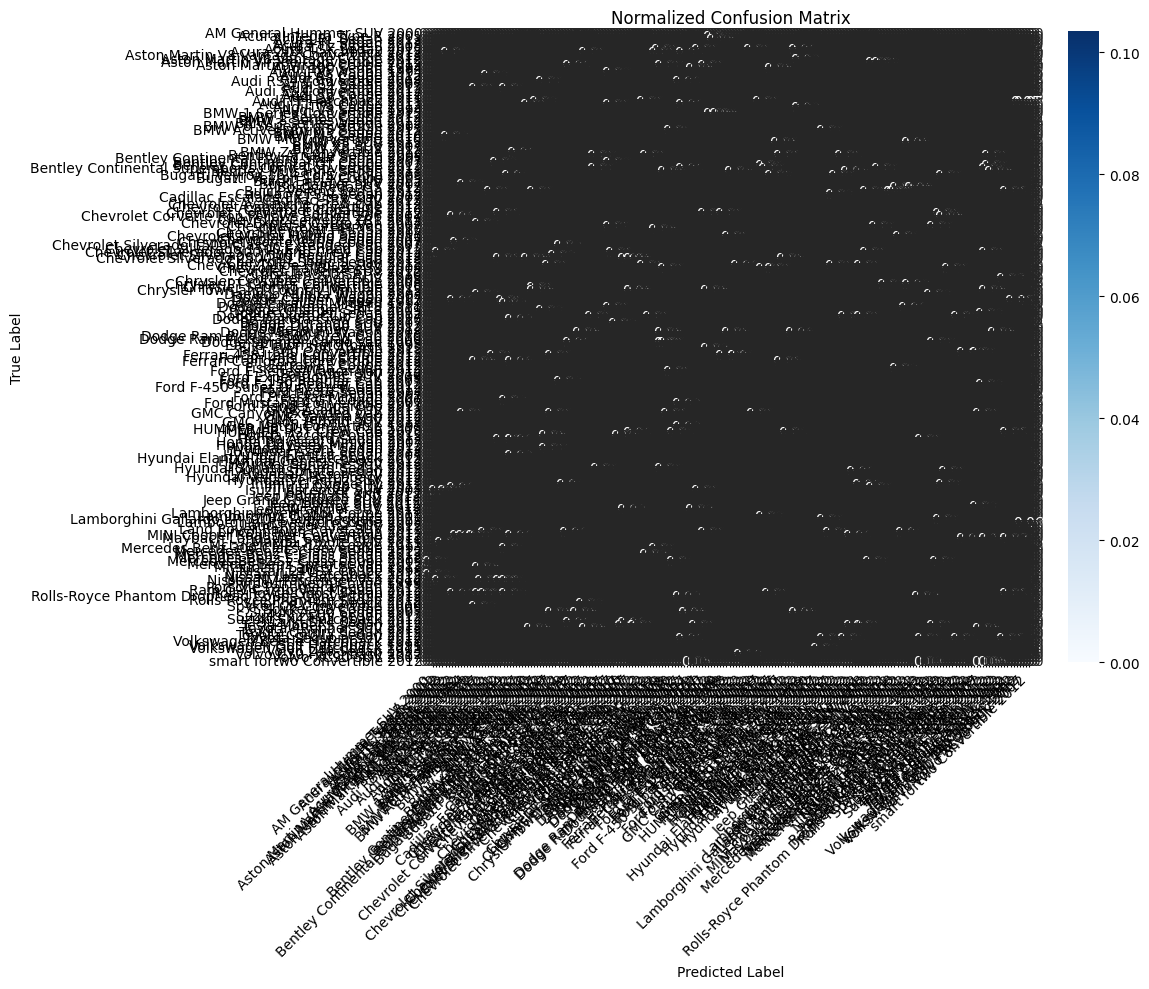

In [15]:
# Compute confusion matrix and normalize it
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotting Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

252/252 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step


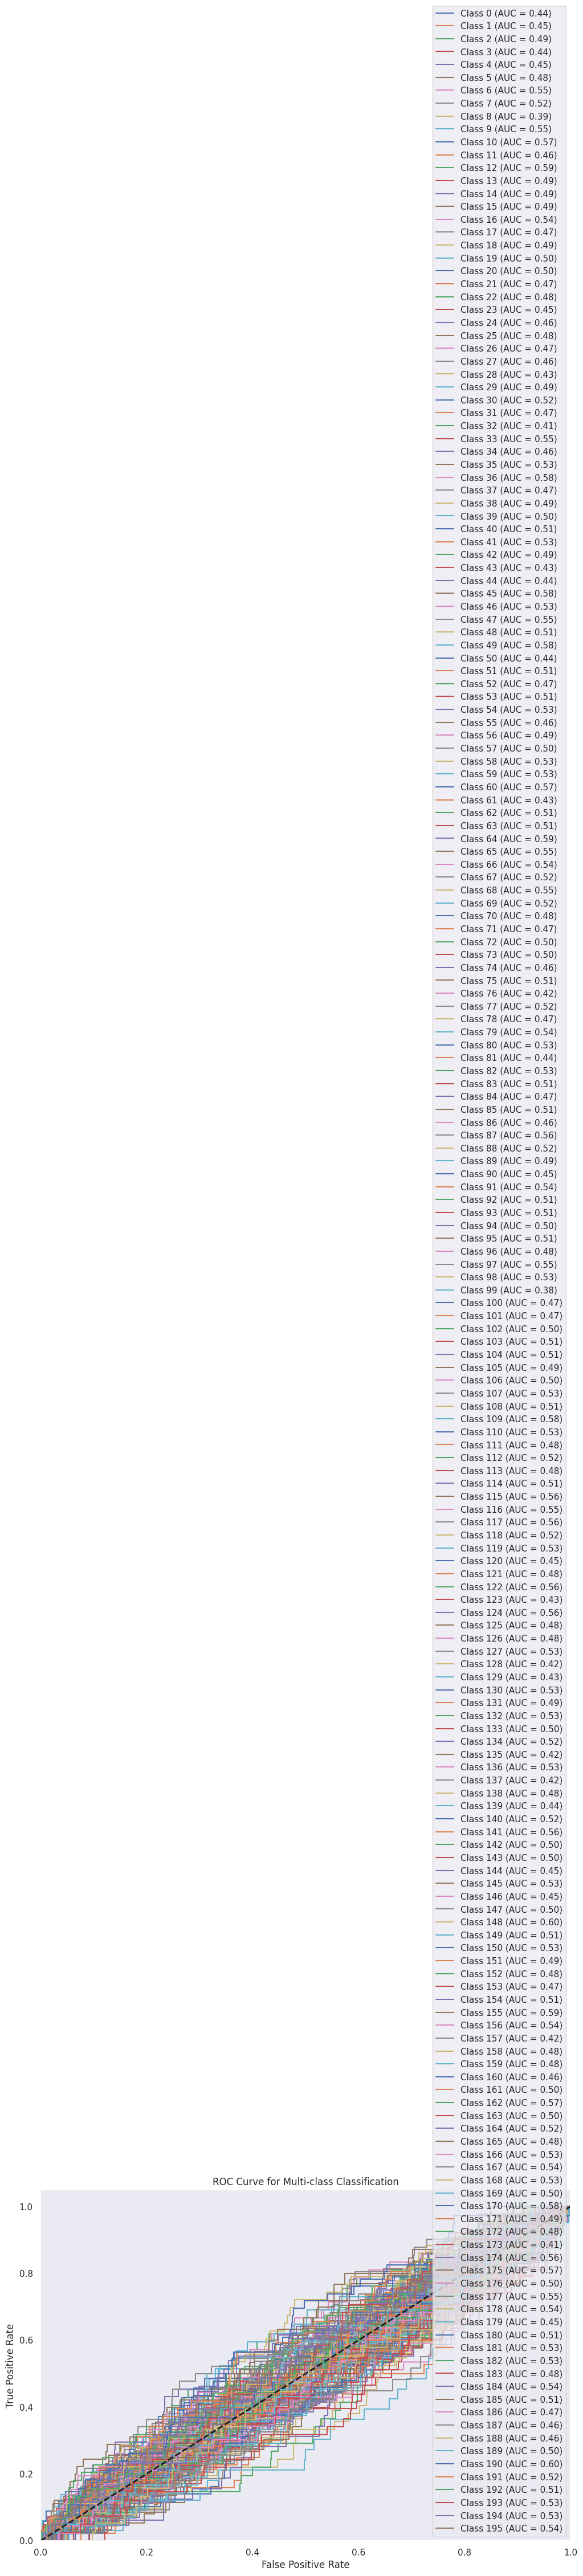

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels from the validation data generator
true_classes = val_data.classes  # This gives the true labels

# Binarize the output labels for multi-class ROC
n_classes = len(val_data.class_indices)  # Number of classes
true_classes_binarized = label_binarize(true_classes, classes=range(n_classes))

# Get the predicted probabilities for ROC
predicted_probabilities = model.predict(val_data)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()

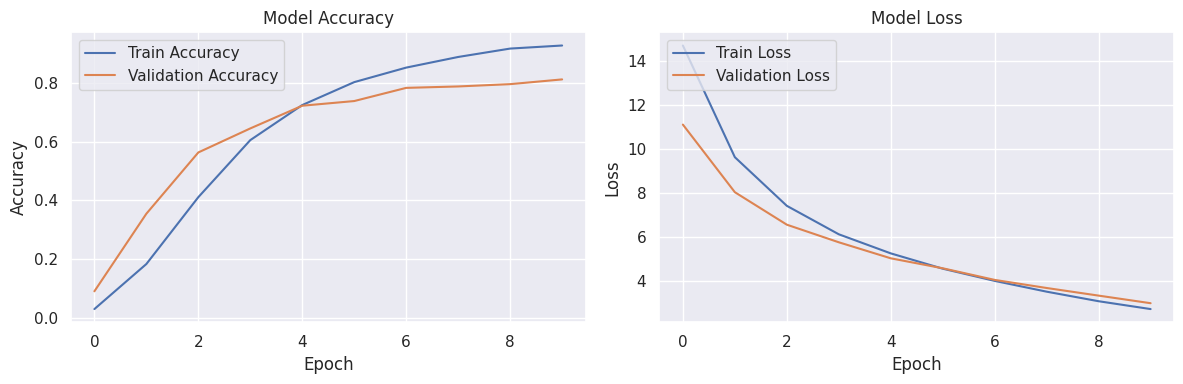

In [25]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()